In [1]:
from dataset import YouCookII
from dataset import collate_fn
from torch.utils.data import DataLoader
from loss import loss_RA_MIL
from transformers import get_linear_schedule_with_warmup
from model import Model

import numpy as np
import torch
import matplotlib.pyplot as plt

def train(model, num_actions, batch_size, epochs=25, lr=0.001, y=0.5):
    dataset = YouCookII(num_actions, "/h/sagar/ece496-capstone/datasets/ycii")
    train_size = int(len(dataset) * (2/3))
    valid_size = int(len(dataset) - train_size)
    
    train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])
    
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = get_linear_schedule_with_warmup(optimizer, int(0.2*epochs), epochs)

    train_loss = np.zeros(epochs)
    valid_loss = np.zeros(epochs)
    
    model.train()
    
    for epoch in range(epochs):
        epoch_loss = 0.0
        num_batches = 0
        for data in train_dataloader:
            _, bboxes_tensor, features_tensor, steps_list, _, entity_count_list, _, _ = data
            batch_size = len(data[0])
            
            # Zero out any gradients.
            optimizer.zero_grad()

            # Run inference (forward pass).            
            loss_E, loss_V, loss_R, _, _, _, _, _ = model(batch_size, num_actions + 1, steps_list, features_tensor, bboxes_tensor, entity_count_list)

            # Loss from alignment.
            loss_ = loss_RA_MIL(y, loss_R, loss_E, loss_V)

            # Backpropagation (backward pass).
            loss_.backward()

            # Update parameters.
            optimizer.step()
            
            epoch_loss += loss_
            num_batches += 1
        
        #learning rate schedule
        #update after each epoch
        scheduler.step()
        epoch_loss = epoch_loss / num_batches
        
        # Save loss and accuracy at each epoch, plot (and checkpoint).
        train_loss[epoch] = epoch_loss
        valid_loss[epoch] = get_validation_loss(num_actions, y, valid_dataloader)
        
        #after epoch completes
        print("Epoch {} - Train Loss: {}, Validation Loss: {}".format(epoch + 1, train_loss[epoch], valid_loss[epoch]))
    
    plt.plot(train_loss, label='train loss')
    plt.plot(valid_loss, label='valid loss')
    plt.legend()
    plt.show()
        
    return train_loss, valid_loss

def get_validation_loss(num_actions, y, valid_dataloader):
    epoch_loss = 0.0
    num_batches = 0
        
    with torch.no_grad():
        for data in valid_dataloader:
            _, bboxes_tensor, features_tensor, steps_list, _, entity_count_list, _, _ = data
            batch_size = len(data[0])

            # Run inference (forward pass).
            loss_E, loss_V, loss_R, _, _, _, _, _ = model(batch_size, num_actions + 1, steps_list, features_tensor, bboxes_tensor, entity_count_list)

            # Loss from alignment.
            loss_ = loss_RA_MIL(y, loss_R, loss_E, loss_V)
            
            epoch_loss += loss_
            num_batches += 1
            
    epoch_loss = epoch_loss / num_batches
    
    return epoch_loss

Epoch 1 - Train Loss: 863.331298828125, Validation Loss: 626.4698486328125
Epoch 2 - Train Loss: 569.71923828125, Validation Loss: 369.1639099121094
Epoch 3 - Train Loss: 422.9540710449219, Validation Loss: 646.3888549804688
Epoch 4 - Train Loss: 595.7706909179688, Validation Loss: 480.586181640625
Epoch 5 - Train Loss: 539.5859375, Validation Loss: 506.19390869140625
Epoch 6 - Train Loss: 611.265869140625, Validation Loss: 422.3387145996094
Epoch 7 - Train Loss: 340.3454284667969, Validation Loss: 118.27587127685547
Epoch 8 - Train Loss: 414.56524658203125, Validation Loss: 1749.2244873046875
Epoch 9 - Train Loss: 602.2266235351562, Validation Loss: 1056.968994140625
Epoch 10 - Train Loss: 760.1084594726562, Validation Loss: 234.3061065673828
Epoch 11 - Train Loss: 271.43682861328125, Validation Loss: 629.24267578125
Epoch 12 - Train Loss: 197.0801544189453, Validation Loss: 381.3611755371094
Epoch 13 - Train Loss: 190.84933471679688, Validation Loss: 277.6313171386719
Epoch 14 - Trai

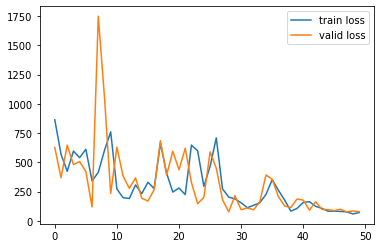

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Model(device)
#model.load_state_dict(torch.load("/h/sagar/ece496-capstone/weights/weights"))

train_loss, valid_loss = train(model, 8, 2, epochs=50, lr=1e-4)

Action 1: cut the wing at the two joints
-------------------------------
the wing -> Action 8 ([NULL])
the two joints -> Action 8 ([NULL])


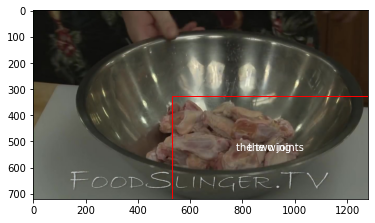

Action 2: mix salt seasoning pepper and baking powder in a bowl
-------------------------------
a bowl -> Action 8 ([NULL])


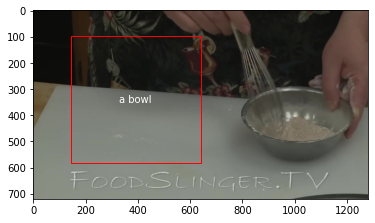

Action 3: coat the wings in the seasoning mix
-------------------------------
the wings -> Action 0 (cut the wing at the two joints)
the seasoning mix -> Action 1 (mix salt seasoning pepper and baking powder in a bowl)


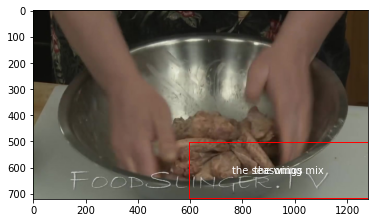

Action 4: cook the wings in the oven
-------------------------------
the wings -> Action 2 (coat the wings in the seasoning mix)
the oven -> Action 0 (cut the wing at the two joints)


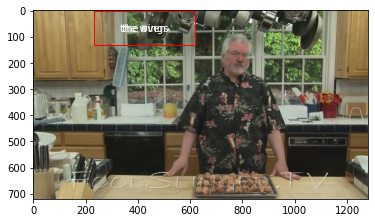

Action 5: flip the wings
-------------------------------
the wings -> Action 3 (cook the wings in the oven)


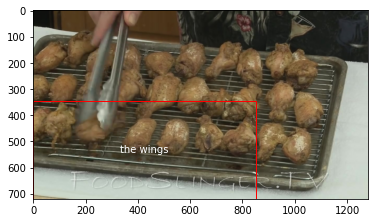

Action 6: cook the wings in the oven
-------------------------------
the wings -> Action 4 (flip the wings)
the oven -> Action 4 (flip the wings)


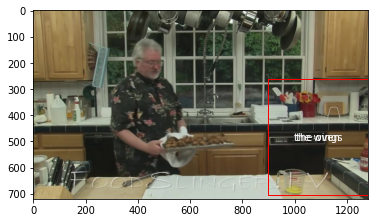

Action 7: mix hot sauce and melted butter together
-------------------------------
hot sauce -> Action 3 (cook the wings in the oven)


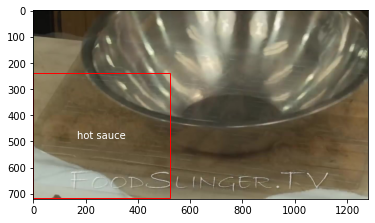

Action 8: coat the wings in sauce
-------------------------------
the wings -> Action 6 (mix hot sauce and melted butter together)
sauce -> Action 6 (mix hot sauce and melted butter together)


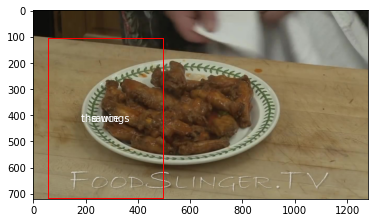

In [4]:
from visualizer import inference

VG, RR, frame_paths = inference(model, 8, 40)

In [9]:
VG

tensor([[65, 65],
        [93, 50],
        [34, 34],
        [82, 82],
        [15, 37]], device='cuda:0')

In [12]:
torch.save(model.state_dict(), "/h/sagar/ece496-capstone/weights/weights")